In [1]:
import pandas as pd
import os,sys
import unagi
from astropy.utils.data import download_file
from IPython.display import Image
from IPython.core.display import HTML 

In [2]:
dr_string = 'dr3'
re_string = 's20a_wide'
csv_file = f'Catalogues/hsc-{dr_string}-{re_string}-specz.csv'

bands = ['g','r','i','z','y']

# conditions that coadds must be at final data quality
if 'dud' in re_string:
    final_conditions = [
        'g_inputcount_value>=28',
        'r_inputcount_value>=28',
        'i_inputcount_value>=38',
        'z_inputcount_value>=63',
        'y_inputcount_value>=38',
    ]
else:
    final_conditions = [
        'g_inputcount_value>=4',
        'r_inputcount_value>=4',
        'i_inputcount_value>=6',
        'z_inputcount_value>=6',
        'y_inputcount_value>=6',
    ]

clean = True

if not os.access(csv_file,0):
    
    dr = unagi.hsc.Hsc(dr=dr_string, rerun=re_string)
    sql_cmd = [
        f'SELECT f.object_id, f2.i_sdsscentroid_ra, f2.i_sdsscentroid_dec, z.specz_redshift',
        f'FROM {re_string}.forced as f',
        f'LEFT JOIN {re_string}.forced2 as f2',
        f'ON f.object_id = f2.object_id',
        f'LEFT JOIN {re_string}.specz as z',
        f'ON f.object_id = z.object_id',
        f'WHERE z.specz_redshift>0.01 AND z.specz_redshift<3'
              ]
    sql_cmd = ' '.join(sql_cmd)
    if clean:
        sql_cmd += ' '+' '.join([f'AND {final_condition}' for final_condition in final_conditions])
    df = dr.sql_query(sql_cmd, from_file=False, verbose=True).to_pandas()
    df.to_csv(csv_file,index=False)
else:
    df = pd.read_csv(csv_file)

374760


<BarContainer object of 99 artists>

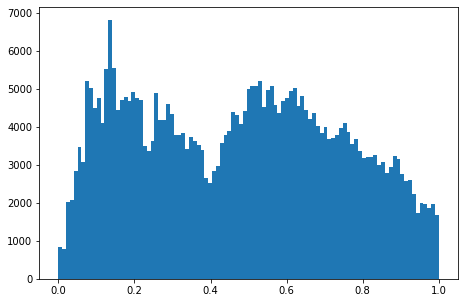

In [3]:
import matplotlib.pyplot as plt
import numpy as np
xmin,xmax=0.,1.
fig,ax = plt.subplots(figsize=(7.5,5))
xedges = np.linspace(0,1,100)
xwidths = xedges[1:]-xedges[:-1]
H,xedges = np.histogram(df['specz_redshift'],bins=xedges,density=False)
print(np.sum(H))
ax.bar(xedges[:-1],H,width=xwidths,align='edge')


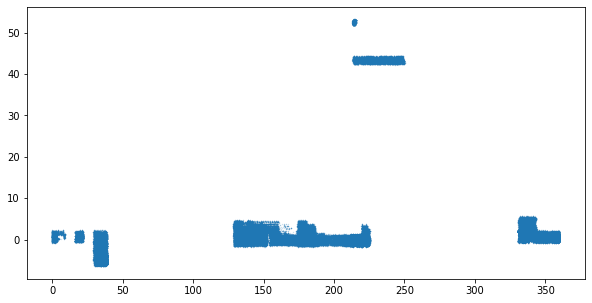

In [4]:
fig,ax=plt.subplots(figsize=(10,5))
ax.scatter(df.i_sdsscentroid_ra,df.i_sdsscentroid_dec,s=0.1,alpha=0.3)

In [5]:
import unagi
dr = unagi.hsc.Hsc(dr=dr_string, rerun=re_string)
dr.tables()

# Get table list from /home/connor.bottrell/.conda/envs/tf39_cpu/lib/python3.9/site-packages/unagi-0.1.3.dev13-py3.9.egg/unagi/data/s20a_wide/s20a_wide_tables.fits
# Read from saved file /home/connor.bottrell/.conda/envs/tf39_cpu/lib/python3.9/site-packages/unagi-0.1.3.dev13-py3.9.egg/unagi/data/s20a_wide/s20a_wide_tables.fits


['calibframe',
 'forced',
 'forced2',
 'forced3',
 'forced4',
 'forced5',
 'frame',
 'frame_hpx11',
 'mag_corr',
 'masks_test20200303',
 'meas',
 'meas2',
 'meas3',
 'meas4',
 'mosaic',
 'mosaic_hpx11',
 'mosaicframe',
 'patch_qa',
 'random',
 'random_masks_test20200303',
 'specz',
 'summary',
 'warped',
 'warped_hpx11']

In [38]:
import astropy.units as u
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy.io import fits

def load_src_cat(data_release,rerun,clean=True):
    '''Generate/load Source catalogue for data release / rerun.'''
    csv_file = f'Catalogues/hsc-{data_release}-{rerun}-specz.csv'
    if not os.access(csv_file,0):
        dr = unagi.hsc.Hsc(dr=data_release, rerun=rerun)
        sql_cmd = [
            f'SELECT f.object_id, f2.i_sdsscentroid_ra, f2.i_sdsscentroid_dec,',
            f'z.specz_redshift',
            f'FROM {rerun}.forced as f',
            f'LEFT JOIN {rerun}.forced2 as f2',
            f'ON f.object_id = f2.object_id',
            f'LEFT JOIN {rerun}.specz as z',
            f'ON f.object_id = z.object_id',
            f'WHERE z.specz_redshift>=0.0001'
                  ]
        sql_cmd = ' '.join(sql_cmd)
        if clean:
            sql_cmd += ' '+' '.join([f'AND {cnd}' for cnd in hsc_coadd_cnds(rerun)])
        df = dr.sql_query(sql_cmd, from_file=False, verbose=True).to_pandas()
        df.to_csv(csv_file,index=False)
    else:
        df = pd.read_csv(csv_file)
    return df  

df = load_src_cat('dr3','s20a_wide')

lowz_df = df.loc[df.specz_redshift<0.02]
galaxy = lowz_df.iloc[200]

coord_1 = SkyCoord(galaxy.i_sdsscentroid_ra, galaxy.i_sdsscentroid_dec, frame='icrs', unit='deg')
s_ang = 40. * u.arcsec

# if not os.access('Cutouts/test_g.fits',0):
cutout_list = unagi.task.hsc_cutout(coord_1, cutout_size=s_ang, filters='grizy', archive=dr, 
                         use_saved=False, output_dir='Cutouts', verbose=False, prefix='test',
                         save_output=True)
for cutout_test in cutout_list:
    cutout_test.close()
    
_filename = 'Cutouts/test_{}.fits'

hsc_scale = 0.168 # arcsec/pixel
# data = fits.getdata(_filename.format('i'))
fig,axarr = plt.subplots(1,5,figsize=(25,5))

for i,band in enumerate(['g','r','i','z','y']):
    
    ax = axarr[i]
    data = fits.getdata(_filename.format(band))
    header = fits.getheader(_filename.format(band))
    f0 = header['FLUXMAG0']
    bkg = header['BGMEAN']
    ax.imshow(-2.5*np.log10((data)/f0/hsc_scale**2),vmin=16,vmax=24,cmap='bone',origin='lower')

AttributeError: 'Series' object has no attribute 'i_sdsscentroid_ra'

In [1]:
def make_bottrell_rgb(rgb,stretch=99,q=5,scale_r=1.,scale_g=1.,scale_b=1.):
    '''Convert images in rgb format (x,y,images).'''
    # assume images are in mag/arcsec2
    rgb = 10**(0.4*(22.5-rgb))
    rgb_scaled = np.tanh(rgb/np.percentile(rgb,stretch)*q)
    rgb_scaled[...,0]*=scale_r
    rgb_scaled[...,1]*=scale_g
    rgb_scaled[...,2]*=scale_b
    return rgb_scaled

def hsc_calibrate(filename,pixelscale=0.168):
    data = fits.getdata(filename)
    hdr = fits.getheader(filename)
    f0 = header['FLUXMAG0']
    data = -2.5*np.log10(data/f0/pixelscale**2) # mag/arscec2
    data[np.isnan(data)]=99
    return data

data_g = hsc_calibrate('Cutouts/test_g.fits')
data_r = hsc_calibrate('Cutouts/test_r.fits')
data_i = hsc_calibrate('Cutouts/test_i.fits')

rgb = np.stack([data_i,data_r,data_g])
rgb = rgb.transpose((1,2,0))
print(rgb.shape)

fig,ax = plt.subplots(figsize=(10,10))
rgb_scaled = make_bottrell_rgb(rgb,scale_r=1.,scale_g=1.,scale_b=1.2,q=1.)
ax.imshow(rgb_scaled, origin='lower', interpolation='None',aspect='auto')





NameError: name 'fits' is not defined

In [1]:
import pandas as pd
import numpy as np
import os,sys
import astropy.units as u
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy.io import fits
import unagi
import tempfile

def hsc_coadd_cnds(rerun):
    '''Conditions that HSC coadds must be at final data quality.'''
    if 'dud' in rerun:
        cnds = [
            'g_inputcount_value>=28',
            'r_inputcount_value>=28',
            'i_inputcount_value>=38',
            'z_inputcount_value>=63',
            'y_inputcount_value>=38',
        ]
    else:
        cnds = [
            'g_inputcount_value>=4',
            'r_inputcount_value>=4',
            'i_inputcount_value>=6',
            'z_inputcount_value>=6',
            'y_inputcount_value>=6',
        ]
    return cnds
    
def load_src_cat(data_release,rerun,clean=True):
    '''Generate/load Source catalogue for data release / rerun.'''
    csv_file = f'Catalogues/hsc-{data_release}-{rerun}-specz.csv'
    if not os.access(csv_file,0):
        dr = unagi.hsc.Hsc(dr=data_release, rerun=rerun)
        sql_cmd = [
            f'SELECT f.object_id, f.ra, f.dec,',
            f'z.specz_redshift',
            f'FROM {rerun}.forced as f',
            f'LEFT JOIN {rerun}.forced2 as f2',
            f'ON f.object_id = f2.object_id',
            f'LEFT JOIN {rerun}.specz as z',
            f'ON f.object_id = z.object_id',
            f'WHERE z.specz_redshift>=0.0001'
                  ]
        sql_cmd = ' '.join(sql_cmd)
        if clean:
            sql_cmd += ' '+' '.join([f'AND {cnd}' for cnd in hsc_coadd_cnds(rerun)])
            sql_cmd += ' ORDER BY f.object_id'
        df = dr.sql_query(sql_cmd, from_file=False, verbose=True).to_pandas()
        df.to_csv(csv_file,index=False)
    else:
        df = pd.read_csv(csv_file)
    return df  

def cutout_radec(data_release,rerun,ra,dec,fov_arcsec=60.,
                 bands=['g','r','i','z','y'],out_dir='.',out_prefix='HSC_Cutout'):
    '''Extract square HSC cutout centered at (ra,dec) [degrees] with full-width fov_arscec [arcsec] in band(s).'''
    dr = unagi.hsc.Hsc(dr=data_release, rerun=rerun)
    if type(bands)!=list:
        bands = list(bands)
    ctr_coord = SkyCoord(ra, dec, frame='icrs', unit='deg')
    fov_arcsec *= u.arcsec
    cutouts = unagi.task.hsc_cutout(ctr_coord, cutout_size=fov_arcsec, filters=''.join(bands), archive=dr, 
                             use_saved=False, output_dir=out_dir, verbose=False, prefix=out_prefix,img_type='coadd',
                             save_output=True, variance=True, mask=True)
    if type(cutouts)!=list:
        cutouts.close()
    else:
        for cutout in cutouts:
            cutout.close()
    return
    
def make_bottrell_rgb(rgb,stretch=99,q=5,scale_r=1.,scale_g=1.,scale_b=1.):
    '''Convert images in rgb format (x,y,images).'''
    # assume images are in mag/arcsec2
    rgb = 10**(0.4*(22.5-rgb))
    rgb_scaled = np.tanh(rgb/np.percentile(rgb,stretch)*q)
    rgb_scaled[...,0]*=scale_r
    rgb_scaled[...,1]*=scale_g
    rgb_scaled[...,2]*=scale_b
    return rgb_scaled

def hsc_calibrate_msb(filename,pixelscale=0.168):
    '''Calibrate HSC image to magnitude surface brightness [AB mag/arcsec2].'''
    data = fits.getdata(filename)
    hdr = fits.getheader(filename)
    f0 = hdr['FLUXMAG0']
    data = -2.5*np.log10(data/f0/pixelscale**2) # mag/arscec2
    data[np.isnan(data)]=99
    return data   

def hsc_calibrate_nanomaggies(filename,pixelscale=0.168):
    '''Calibrate HSC image to linear AB nanomaggies.'''
    data = fits.getdata(filename)
    hdr = fits.getheader(filename)
    f0 = hdr['FLUXMAG0']
    data = data/f0*1e9 # nanomaggies
    return data   

def cb_plot(nrows=1,ncols=1,sharex=False,sharey=False,panelsize_x=5,panelsize_y=5):
    '''My plotting style.'''
    import matplotlib.pyplot as plt
    from matplotlib import rc
    rc('font',**{'family':'serif'})
    rc('text', usetex=True)
    fig,axarr = plt.subplots(nrows,ncols,figsize=(ncols*panelsize_x,nrows*panelsize_y),sharey=sharey,sharex=sharex)
    for ax in np.asarray([axarr]).flat:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        for spine in ['top','bottom','left','right']:
            ax.spines[spine].set_linewidth(0.5)
            ax.spines[spine].set_color('black')
        fig.subplots_adjust(wspace=0,hspace=0)
    return fig,axarr

def rgb_plot(ax,out_dir,out_prefix,bands=['g','r','i'],scale_r=1.,scale_g=1.,scale_b=1.2,q=1.):
    '''Plot rgb colour image on ax from 3 bands ordered blue/green/red.'''
    data_b = hsc_calibrate_msb(f'{out_dir}/{out_prefix}_{bands[0]}.fits')
    data_g = hsc_calibrate_msb(f'{out_dir}/{out_prefix}_{bands[1]}.fits')
    data_r = hsc_calibrate_msb(f'{out_dir}/{out_prefix}_{bands[2]}.fits')
    rgb = np.stack([data_r,data_g,data_b])
    rgb = rgb.transpose((1,2,0))
    rgb_scaled = make_bottrell_rgb(rgb,scale_r=scale_r,scale_g=scale_g,scale_b=scale_b,q=q)
    ax.imshow(rgb_scaled, origin='lower', interpolation='None',aspect='auto')
    return


def main():
    
    data_release = 'dr3'
    rerun = 's20a_wide'
    df = load_src_cat(data_release,rerun)
    fig_dir = '/lustre/work/connor.bottrell/RealSim_HSC/Figures'
    bands = 'grizy'
    fov_arcsec = 40.
    
    # low-z sample
    lowz_df = df.loc[(df.specz_redshift<0.02) & (df.specz_redshift>0.01)]
    idxs = lowz_df.index
    for idx in idxs:
        galaxy = lowz_df.loc[idx]
        out_prefix = f'HSC_Cutout_{int(galaxy.object_id)}'
        fig_name = f'{fig_dir}/{out_prefix}.pdf'
        if os.access(fig_name,0): continue
        with tempfile.TemporaryDirectory() as out_dir:
            cutout_radec(data_release,rerun,galaxy.ra,galaxy.dec,
                         fov_arcsec=fov_arcsec,bands=bands,out_dir=out_dir,out_prefix=out_prefix)
            fig,axarr = cb_plot(2,3,sharey=True,panelsize_x=5,panelsize_y=5)
            axarr = axarr.flatten()
            for i,band in enumerate(['g','r','i','z','y']):
                filename = f'{out_dir}/{out_prefix}_{band}.fits'
                data = hsc_calibrate_msb(filename)
                ax = axarr[i]
                ax.imshow(data,vmin=16,vmax=26,cmap='bone',origin='lower',aspect='auto',interpolation='None')
            ax = axarr[5]
            rgb_plot(ax,out_dir,out_prefix,q=1)
            fig.savefig(fig_name,bbox_inches='tight')
        
if __name__=='__main__':
    main()

In [36]:
40000*0.5/60/24/4

3.472222222222222

In [59]:
190+189*3

757

In [19]:
import os
import pandas as pd

def load_sql_df(csv_name,dr='dr3',usr_env='SSP_IDR_USR',pwd_env='SSP_IDR_PWD',sql_cmd='SELECT now()'):
    '''Query data base with sql_cmd if csv_name does not exist, else load existing csv file.'''
    if os.access(csv_name,0):
        return pd.read_csv(csv_name,comment='#')
    os.system(f'echo "{sql_cmd}" > cmd.sql')
    sys_cmd = [f'python hscSspQuery3.py',
               f'--user {os.getenv(usr_env)}',
               f'--password-env {pwd_env}',
               f'--nomail',
               f'--release-version {dr}',
               f'--delete-job',
               f'cmd.sql > {csv_name}']
    os.system(' '.join(sys_cmd))
    if os.access('cmd.sql',0): os.remove('cmd.sql')
    with open(csv_name,'r') as f:
        lines = f.readlines()
        col_names = lines[4].replace('# ','')
        lines[4] = col_names
    with open(csv_name,'w') as f:
        f.writelines(lines)
    return pd.read_csv(csv_name,comment='#')

def hsc_coadd_cnds(rerun):
    '''Conditions that HSC coadds must be at final data quality.'''
    if 'dud' in rerun:
        cnds = [
            'g_inputcount_value>=28',
            'r_inputcount_value>=28',
            'i_inputcount_value>=38',
            'z_inputcount_value>=63',
            'y_inputcount_value>=38',
        ]
    else:
        cnds = [
            'g_inputcount_value>=4',
            'r_inputcount_value>=4',
            'i_inputcount_value>=6',
            'z_inputcount_value>=6',
            'y_inputcount_value>=6',
        ]
    return cnds

def main():
    
    dr='dr3'
    rerun = 's20a_wide'
    csv_name = f'Catalogues/HSC-{dr}-{rerun}-photoz_mizuki.csv'
    clean = True
    
    sql_cmd = [
        f'SELECT f.object_id, f.ra, f.dec, f.tract, f.patch,',
        f'z.photoz_best, z.photoz_risk_best, z.prob_gal, z.prob_star, z.prob_qso',
        f'FROM {rerun}.forced as f',
        f'LEFT JOIN {rerun}.photoz_mizuki as z',
        f'ON f.object_id = z.object_id',
        f'WHERE z.photoz_median>0.01 and z.photoz_median<2',
              ]
    sql_cmd = ' '.join(sql_cmd)
    if clean:
        sql_cmd += ' '+' '.join([f'AND {cnd}' for cnd in hsc_coadd_cnds(rerun)])
    sql_cmd += f' ORDER BY f.object_id LIMIT 100;'
    
    df = hsc_sql.load_sql_df(csv_name,dr=dr,sql_cmd=sql_cmd)
    
    print(df.head(100))
    
if __name__=='__main__':
    main()




            object_id         ra       dec  tract  patch  photoz_best  \
0   36411448540270969  30.611445 -6.475494   8279      5         0.93   
1   36411448540271000  30.594238 -6.474626   8279      5         0.85   
2   36411448540271197  30.592653 -6.469386   8279      5         0.70   
3   36411448540271205  30.617303 -6.469029   8279      5         0.17   
4   36411448540271228  30.594655 -6.468498   8279      5         0.58   
..                ...        ...       ...    ...    ...          ...   
95  36411448540286772  30.612817 -6.463998   8279      5         0.63   
96  36411448540286774  30.591672 -6.465210   8279      5         0.48   
97  36411448540286846  30.618519 -6.461346   8279      5         0.88   
98  36411448540286849  30.616576 -6.461201   8279      5         0.51   
99  36411448540286869  30.611926 -6.461399   8279      5         2.02   

    photoz_risk_best  prob_gal  prob_star  prob_qso  
0           0.139571       1.0        0.0       0.0  
1           0.1

In [7]:
#     clean = True
    
#     sql_cmd = [
#         f'SELECT f.object_id, f.ra, f.dec, f.tract, f.patch,',
#         f'z.photoz_best, z.photoz_risk_best, z.prob_gal, z.prob_star, z.prob_qso',
#         f'FROM {rerun}.forced as f',
#         f'LEFT JOIN {rerun}.photoz_mizuki as z',
#         f'ON f.object_id = z.object_id',
#         f'WHERE z.photoz_median>0.01 and z.photoz_median<2',
#               ]
#     sql_cmd = ' '.join(sql_cmd)
#     if clean:
#         sql_cmd += ' '+' '.join([f'AND {cnd}' for cnd in hsc_coadd_cnds(rerun)])
#     sql_cmd += f' ORDER BY f.object_id LIMIT 100;'

NameError: name 'df' is not defined

# Create clean photoz sample from full mizuki catalogue

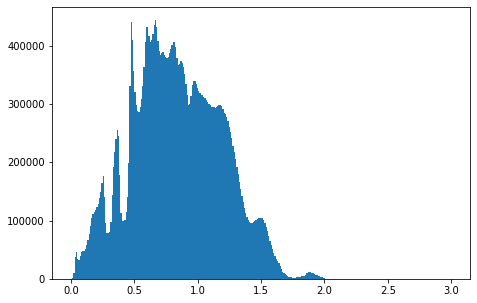

In [89]:
import hsc_sql
import pandas as pd

def main():

    dr='dr3'
    rerun = 's20a_wide'
    csv_name = f'Catalogues/HSC-{dr}-{rerun}-photoz_mizuki.csv'
    clean = True
    
    sql_cmd = [
        f'SELECT f.object_id, f.ra, f.dec, f.tract, f.patch,',
        f'z.photoz_best, z.photoz_risk_best, z.reduced_chisq,',
        f'z.prob_gal, z.prob_star, z.prob_qso',
        f'FROM {rerun}.forced as f',
        f'LEFT JOIN {rerun}.photoz_mizuki as z',
        f'ON f.object_id = z.object_id',
        f'WHERE z.photoz_median>0.01 and z.photoz_median<2',
              ]
    sql_cmd = ' '.join(sql_cmd)
    if clean:
        sql_cmd += ' '+' '.join([f'AND {cnd}' for cnd in hsc_sql.hsc_coadd_cnds(rerun)])
    sql_cmd += f' ORDER BY f.object_id;'
    
    df = hsc_sql.load_sql_df(csv_name,dr=dr,sql_cmd=sql_cmd)
    
    df = df.loc[(df.photoz_risk_best<0.25) & (df.reduced_chisq<5)]
    
    import matplotlib.pyplot as plt
    import numpy as np
    xmin,xmax=0.,3.
    fig,ax = plt.subplots(figsize=(7.5,5))
    xedges = np.linspace(xmin,xmax,300)
    xwidths = xedges[1:]-xedges[:-1]
    H,xedges = np.histogram(df['photoz_best'],bins=xedges,density=False)
    ax.bar(xedges[:-1],H,width=xwidths,align='edge')
    
    # clean photoz catalogue
    df.to_csv(f'Catalogues/HSC-{dr}-{rerun}-photoz_mizuki-CLEAN.csv',columns=['object_id','ra','dec','photoz_best'],index=False)
    
if __name__=='__main__':
    main()




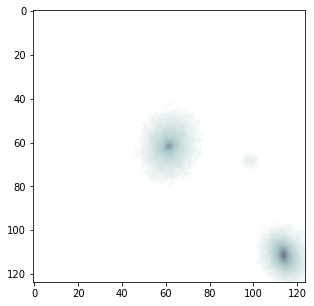

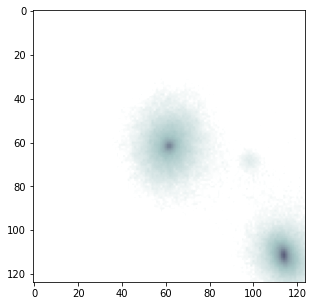

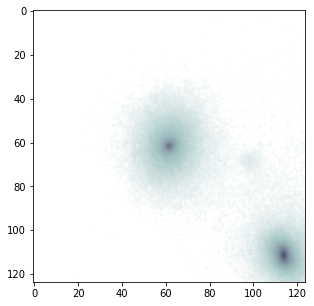

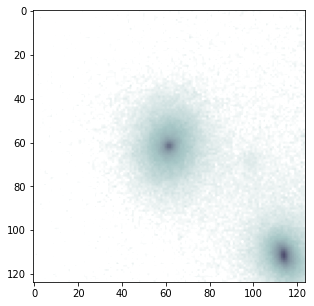

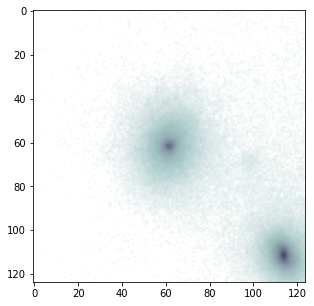

In [83]:
import illustris_python as il
from astropy.io import fits
from astropy.cosmology import Planck15 as cosmo
from scipy.interpolate import RectBivariateSpline
from rebin import rebin

def get_subhalos(basePath,snap,cosmology,mstar_lower=0,mstar_upper=np.inf):
    '''
    mstar_lower and mstar_upper have log10(Mstar/Msun) units and are physical (i.e. Msun, not Msun/h).
    '''
    little_h = cosmology.H0.value/100.
    
    ptNumStars = il.snapshot.partTypeNum('stars') 
    fields = ['SubhaloMassType','SubhaloFlag']
    subs = il.groupcat.loadSubhalos(basePath,snap,fields=fields)

    mstar = subs['SubhaloMassType'][:,ptNumStars]
    flags = subs['SubhaloFlag']
    subs = np.arange(subs['count'],dtype=int)
    
    # convert to units used by TNG (1e10 Msun/h)
    mstar_lower = 10**(mstar_lower)/1e10*little_h
    mstar_upper = 10**(mstar_upper)/1e10*little_h
    subs = subs[(flags!=0)*(mstar>=mstar_lower)*(mstar<=mstar_upper)]
    return subs,mstar[subs]

def cutout_radec(data_release,rerun,ra,dec,fov_arcsec=60.,
                 bands=['g','r','i','z','y'],out_dir='.',out_prefix='HSC_Cutout'):
    '''Extract square HSC cutout centered at (ra,dec) [degrees] with full-width fov_arscec [arcsec] in band(s).'''
    dr = unagi.hsc.Hsc(dr=data_release, rerun=rerun)
    if type(bands)!=list:
        bands = list(bands)
    ctr_coord = SkyCoord(ra, dec, frame='icrs', unit='deg')
    fov_arcsec *= u.arcsec
    cutouts = unagi.task.hsc_cutout(ctr_coord, cutout_size=fov_arcsec, filters=''.join(bands), archive=dr, 
                             use_saved=False, output_dir=out_dir, verbose=False, prefix=out_prefix,img_type='coadd',
                             save_output=True, variance=True, mask=True)
    if type(cutouts)!=list:
        cutouts.close()
    else:
        for cutout in cutouts:
            cutout.close()
    return

def hsc_calibrate_msb(filename,pixelscale=0.168):
    '''Calibrate HSC image to magnitude surface brightness [AB mag/arcsec2].'''
    data = fits.getdata(filename)
    hdr = fits.getheader(filename)
    f0 = hdr['FLUXMAG0']
    data = -2.5*np.log10(data/f0/pixelscale**2) # mag/arscec2
    data[np.isnan(data)]=99
    return data   

def hsc_calibrate_nanomaggies(filename,pixelscale=0.168):
    '''Calibrate HSC image to linear AB nanomaggies.'''
    data = fits.getdata(filename)
    hdr = fits.getheader(filename)
    f0 = hdr['FLUXMAG0']
    data = data/f0*1e9 # nanomaggies
    return data   


def realsim(il_path,img_path,sim_tag,snap,sub,cam,
            filters = 'GRIZY',hsc_arcsec_per_pixel=0.168):
    
    filename = f'{img_path}/{snap:03}/shalo_{snap:03}-{sub}_{cam}_photo.fits'
    if not os.access(filename,0):
        print(f'File: {filename} not found.\n')
        return
    filters = [f'SUBARU_HSC.{filt}' for filt in filters]
    
    for i,filt in enumerate(filters):
        # image data and header information
        data = fits.getdata(filename,filt)
        hdr = fits.getheader(filename,filt)
        redshift = hdr['Redshift']
        npixels = hdr['NAXIS1']
        kpc_per_pixel = hdr['CDELT1']/1000.
        kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(z=redshift).value/60.
        arcsec_per_pixel = kpc_per_pixel/kpc_per_arcsec
        fov_kpc = kpc_per_pixel*npixels
        fov_arcsec = fov_kpc/kpc_per_arcsec

        # convert data to nanomaggies from AB surface brightness
        data =  10**(0.4*(22.5-data))*arcsec_per_pixel**2 
        # rebin to hsc ccd scale
        npixels_hsc = int(np.floor(fov_arcsec/hsc_arcsec_per_pixel))
        if npixels < npixels_hsc:
            interp = RectBivariateSpline(np.linspace(-1,1,npixels),np.linspace(-1,1,npixels),data,kx=1,ky=1)
            data = interp(np.linspace(-1,1,npixels_hsc),np.linspace(-1,1,npixels_hsc))*(npixels/npixels_hsc)**2
        else:
            data = rebin(data,(npixels_hsc,npixels_hsc))
     
def main():
    
    sim_tag = 'TNG50-1'
    snap = 91
    sub = 100
    cam = 'v0'
    
    project_path = '/lustre/work/connor.bottrell/Simulations/IllustrisTNG'
    # base path where TNG data is stored
    il_path = f'{project_path}/{sim_tag}/output'
    # photometry path
    img_path = f'{project_path}/{sim_tag}/postprocessing/Photometry'

    realsim(il_path,img_path,sim_tag,snap,sub,cam)

    
            
        
if __name__=='__main__':
    
    main()
            
            
        
        
    

In [92]:
df.head(20)

,object_id,ra,dec,photoz_best
0,36411448540270969,30.611445,-6.475494,0.93
1,36411448540271000,30.594238,-6.474626,0.85
2,36411448540271247,30.614707,-6.467907,0.50
3,36411448540271342,30.615733,-6.464985,1.51
4,36411448540271359,30.590714,-6.464553,1.02
5,36411448540271417,30.594507,-6.462934,0.63
6,36411448540271428,30.572571,-6.462894,0.68
7,36411448540271445,30.621719,-6.462179,0.93
8,36411448540271510,30.591963,-6.460950,0.84
9,36411448540271585,30.619585,-6.458488,0.62


In [2]:
import os,sys,requests
import tarfile,tempfile

def make_cutout_list(object_id,ra,dec,tmp_dir,dr='dr3',rerun='s20a_wide',
                     filters='GRIZY',fov_arcsec=30, mask=True, variance=True):
    '''
    Generate cutout list for a single object_id,ra,dec with formatting described here:
    https://hscdata.mtk.nao.ac.jp/das_quarry/dr3/manual.html#list-to-upload
    
    Filters must be a single string of capitalized filter names (default 'GRIZY').
    fov_arcec is the full-width size of the desired cutouts.
    mask and variance images are included by default.
    tmp_dir is the location of the output cutout list (txt file).
    '''
    das_header = "#? rerun filter ra dec sw sh image mask variance type # object_id\n"
    das_list = []
    for filt in filters:
        row = f" {rerun} HSC-{filt} {ra} {dec} {fov_arcsec/2}asec {fov_arcsec/2}asec true {mask} {variance} coadd # {object_id}"
        das_list.append(row)

    cutout_list = f"{tmp_dir}/{object_id}_list.txt"
    with open(cutout_list, "w") as f:
        f.write(das_header)
        f.write("\n".join(das_list))
    return cutout_list


def download_cutouts(cutout_list,dr,rerun,tmp_dir):
    '''
    Download cutout file from list (txt file). 
    List formatting is described here:
    https://hscdata.mtk.nao.ac.jp/das_quarry/dr3/manual.html#list-to-upload
    
    Tested for dr3 and dr4. 
    Earlier releases use different urls for the archive.
    tmp_dir is the directory where the downloaded tar file is stored.
    '''

    creds = {
        "user":os.getenv('SSP_IDR_USR'),
        "secret":os.getenv('SSP_IDR_PWD')
    }
    tar_downld = f'{tmp_dir}/hsc_cutouts.tar' 
    with open(cutout_list, "r") as f:
        while True:
            r = requests.post(f"https://hscdata.mtk.nao.ac.jp/das_quarry/{dr}/cgi-bin/cutout",
                                files={"list":f},
                                auth=(creds["user"],creds["secret"]),
                                stream=True)
            if r.status_code!=200:
                print(f"Failed Download for: {cutout_list}. HTTP Code: {r.status_code}. Waiting 30 seconds...")
                time.sleep(30)
            else:
                break
                
    with open(tar_downld, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
                
    if os.access(cutout_list,0):os.remove(cutout_list)
        
    return tar_downld
        
                
def get_cutouts(object_id,ra,dec,out_dir,dr='dr3',rerun='s20a_wide',
                filters='GRIZY',fov_arcsec=30, mask=True, variance=True):
    '''
    Get cutouts of size fov_arcsec [arcsec] in filters for a given ra,dec. 
    object_id is arbitrary and only used for naming.
    dr and rerun are the data release and rerun.
    filters must be a single string.
    
    All intermediate steps are performed in a temporary directory.
    Cutouts go to out_dir.
    '''

    with tempfile.TemporaryDirectory() as tmp_dir:
        
        cutout_list = make_cutout_list(object_id,ra,dec,tmp_dir,dr,rerun,
                                       filters,fov_arcsec,mask,variance)
        
        tar_downld = download_cutouts(cutout_list,dr,rerun,tmp_dir)
            
        with tarfile.TarFile(tar_downld, 'r') as tarball:
            tarball.extractall(tmp_dir)
            
        if os.access(tar_downld,0): 
            os.remove(tar_downld)
            
        sub_dir = os.listdir(tmp_dir)[0]
        
        os.system(f'cp {tmp_dir}/{sub_dir}/*.fits {out_dir}')
        

def main():
    
    '''
    Example usage.
    '''

    object_id,ra,dec,out_dir = '36411448540270969',30.611445,-6.475494,'Cutouts'
    
    get_cutouts(object_id,ra,dec,out_dir,dr='dr3',rerun='s19a_wide',filters='GRIZY',fov_arcsec=120)
    
if __name__=='__main__':
    
    main()



In [3]:
from astropy.io import fits

hdu = fits.open('Cutouts/2-cutout-HSC-G-8279-s20a_wide.fits')
hdu[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
COMMENT DAS Cutout version 200424                                               
HIERARCH variance_scale = 1.12444361477295                                      
BGMEAN  =  0.00695275141078875                                                  
BGVAR   = 0.000353884050711032                                                  
HIERARCH EXPINFO_V = 1                                                          
AR_HDU  =                    5 / HDU (1-indexed) containing the archive used to 
HIERARCH TRANSMISSION_CURVE_

In [1]:
from hsc_utils import hsc_image

object_id,ra,dec,out_dir = '36411448540270969',30.611445,-6.475494,'Cutouts'

hsc_image.get_cutouts(object_id,ra,dec,out_dir,dr='dr4',rerun='s21a_wide',filters='GRIZY',fov_arcsec=120)


# Get psf reconstruction file.

In [2]:
import os,sys,time,requests
import tarfile,tempfile

def make_psf_list(object_id,ra,dec,tmp_dir,dr='dr3',rerun='s20a_wide',filters='GRIZY'):
    '''
    Generate PSF list for a single object_id,ra,dec with formatting described here:
    https://hscdata.mtk.nao.ac.jp/psf/8/manual.html#Bulk_mode
    
    object_id is only meaninful for filename conventions. It is arbitrary.
    
    Filters must be a single string of capitalized filter names (default 'GRIZY').
    tmp_dir is the location of the output cutout list (txt file).
    '''
    
    das_header = "#? ra dec rerun filter type centered # object_id\n"
    das_list = []
    for filt in filters:
        if filt in ['G','R','I','Z','Y']:
            filt = filt.lower()
        row = f" {ra} {dec} {rerun} {filt} coadd false # {object_id}"
        das_list.append(row)

    psf_list = f"{tmp_dir}/{object_id}_psflist.txt"
    with open(psf_list, "w") as f:
        f.write(das_header)
        f.write("\n".join(das_list))
    return psf_list

def download_psfs(psf_list,dr,rerun,tmp_dir):
    '''
    Download PSF files from list (txt file). 
    List formatting is described here:
    https://hscdata.mtk.nao.ac.jp/psf/8/manual.html#Bulk_mode
    
    Tested for dr3 and dr4. 
    Earlier releases use different urls for the archive.
    tmp_dir is the directory where the downloaded tar file is stored.
    '''

    creds = {
        "user":os.getenv('SSP_IDR_USR'),
        "secret":os.getenv('SSP_IDR_PWD')
    }
    tar_downld = f'{tmp_dir}/hsc_psfs.tar' 
    with open(psf_list, "r") as f:
        while True:
            r = requests.post(f"https://hscdata.mtk.nao.ac.jp/psf/8/cgi/getpsf?bulk=on",
                                files={"list":f},
                                auth=(creds["user"],creds["secret"]),
                                stream=True)
            if r.status_code!=200:
                print(f"Failed Download for: {psf_list}. HTTP Code: {r.status_code}. Waiting 30 seconds...")
                time.sleep(30)
            else:
                break
                
    with open(tar_downld, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
                
    if os.access(psf_list,0):os.remove(psf_list)
        
    return tar_downld

def get_psfs(object_id,ra,dec,out_dir,dr='dr3',rerun='s20a_wide',filters='GRIZY'):
    '''
    Get cutouts of size fov_arcsec [arcsec] in filters for a given ra,dec. 
    object_id is arbitrary and only used for naming.
    dr and rerun are the data release and rerun.
    filters must be a single string.
    
    All intermediate steps are performed in a temporary directory.
    Cutouts go to out_dir.
    
    Example usage:
    ##############
    
    import hsc_psf

    object_id,ra,dec,out_dir = '36411448540270969',30.611445,-6.475494,'PSFs'
    
    hsc_psf.get_psfs(object_id,ra,dec,out_dir,dr='dr4',rerun='s21a_wide',filters='GRIZY')
    '''

    with tempfile.TemporaryDirectory() as tmp_dir:
        
        psf_list = make_psf_list(object_id,ra,dec,tmp_dir,dr,rerun,filters)
        
        tar_downld = download_psfs(psf_list,dr,rerun,tmp_dir)
            
        with tarfile.TarFile(tar_downld, 'r') as tarball:
            tarball.extractall(out_dir)
            
        if os.access(tar_downld,0): 
            os.remove(tar_downld)

        
def main():

    object_id,ra,dec,out_dir = '36411448540270969',35.72187,-5.31932,'PSFs'
    
    get_psfs(object_id,ra,dec,out_dir,dr='dr4',rerun='s21a_wide',filters='GRIZY')

if __name__=='__main__':
    main()

In [2]:
import hsc_psf

object_id,ra,dec,out_dir = '36411448540270969',30.611445,-6.475494,'PSFs'

hsc_psf.get_psfs(object_id,ra,dec,out_dir,dr='dr4',rerun='s21a_wide',filters='GRIZY')

In [7]:
from hsc_utils import hsc_sql
import os
print(os.path.dirname(hsc_sql.__file__))
import pandas as pd

dr='dr3'
rerun = 's20a_wide'
csv_name = f'HSC-{dr}-{rerun}-test.csv'

sql_cmd=f'SELECT f.object_id, f.ra, f.dec FROM {rerun}.forced as f LIMIT 10'
df = hsc_sql.load_sql_df(csv_name,dr=dr,sql_cmd=sql_cmd)

print(df.head(10))

/home/connor.bottrell/.conda/envs/tf39_cpu/lib/python3.9/site-packages/hsc_utils
           object_id          ra       dec
0  43215509960808166  169.919037  2.729951
1  43215509960808167  170.027952  2.728939
2  43215509960808168  170.027968  2.728117
3  43215509960808169  169.937501  2.729277
4  43215509960808170  169.937436  2.728830
5  43215509960808171  169.938327  2.729333
6  43215509960808172  170.042669  2.729200
7  43215509960808173  170.042230  2.728918
8  43215509960808174  169.945688  2.729466
9  43215509960808175  169.945057  2.729495


# Testing modules



In [1]:
from hsc_utils import hsc_image

object_id,ra,dec='36411448540270969',30.611445,-6.475494
out_dir='/lustre/work/connor.bottrell/RealSim_HSC/Cutouts'

hsc_image.get_cutouts(object_id,ra,dec,out_dir,dr='dr4',rerun='s21a_wide',filters='GRIZY',fov_arcsec=120)

In [3]:
from hsc_utils import hsc_psf

object_id,ra,dec = '36411448540270969',30.611445,-6.475494
out_dir = '/lustre/work/connor.bottrell/RealSim_HSC/PSFs'

hsc_psf.get_psfs(object_id,ra,dec,out_dir,dr='dr4',rerun='s21a_wide',filters='GRIZY')

In [4]:
from hsc_utils import hsc_sql

dr='dr3'
rerun = 's20a_wide'
csv_name = f'HSC-{dr}-{rerun}-test.csv'

sql_cmd=f'SELECT f.object_id, f.ra, f.dec FROM {rerun}.forced as f LIMIT 10'
df = hsc_sql.load_sql_df(csv_name,dr=dr,sql_cmd=sql_cmd)

print(df.head(10))

           object_id          ra       dec
0  43215509960808166  169.919037  2.729951
1  43215509960808167  170.027952  2.728939
2  43215509960808168  170.027968  2.728117
3  43215509960808169  169.937501  2.729277
4  43215509960808170  169.937436  2.728830
5  43215509960808171  169.938327  2.729333
6  43215509960808172  170.042669  2.729200
7  43215509960808173  170.042230  2.728918
8  43215509960808174  169.945688  2.729466
9  43215509960808175  169.945057  2.729495


In [2]:
import os,sys,time,tempfile
import illustris_python as il
from astropy.io import fits
from astropy.cosmology import Planck15 as cosmo
from astropy.convolution import convolve
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from scipy.interpolate import RectBivariateSpline
from hsc_utils import hsc_sql,hsc_image,hsc_psf
from rebin import rebin
import numpy as np
from glob import glob

#rspath = os.path.dirname(__file__)

## for testing only ##
rsdir = '/lustre/work/connor.bottrell/RealSim_HSC'

def get_subhalos(basePath,snap,cosmology,mstar_lower=9,mstar_upper=np.inf):
    '''
    mstar_lower and mstar_upper have log10(Mstar/Msun) units and are physical (i.e. Msun, not Msun/h).
    '''
    little_h = cosmology.H0.value/100.
    
    ptNumStars = il.snapshot.partTypeNum('stars') 
    fields = ['SubhaloMassType','SubhaloFlag']
    subs = il.groupcat.loadSubhalos(basePath,snap,fields=fields)

    mstar = subs['SubhaloMassType'][:,ptNumStars]
    flags = subs['SubhaloFlag']
    subs = np.arange(subs['count'],dtype=int)
    
    # convert to units used by TNG (1e10 Msun/h)
    mstar_lower = 10**(mstar_lower)/1e10*little_h
    mstar_upper = 10**(mstar_upper)/1e10*little_h
    subs = subs[(flags!=0)*(mstar>=mstar_lower)*(mstar<=mstar_upper)]
    return subs,mstar[subs]

def hsc_calibrate_msb(filename,pixelscale=0.168,extension=1):
    '''Calibrate HSC cutout image to magnitude surface brightness [AB mag/arcsec2].'''
    data = fits.getdata(filename,extension)
    hdr = fits.getheader(filename,0)
    f0 = hdr['FLUXMAG0']
    data = -2.5*np.log10(data/f0/pixelscale**2) # mag/arscec2
    data[np.isnan(data)]=99
    return data   

def hsc_calibrate_nanomaggies(filename,pixelscale=0.168,extension=1):
    '''Calibrate HSC cutout image to linear AB nanomaggies.'''
    data = fits.getdata(filename,extension)
    hdr = fits.getheader(filename,0)
    f0 = hdr['FLUXMAG0']
    data = data/f0*1e9 # nanomaggies
    return data   

def hsc_calibrate_variance_nanomaggies(filename,pixelscale=0.168,extension=3):
    '''Calibrate HSC variance image to squared AB nanomaggies.'''
    variance = fits.getdata(filename,extension)
    hdr = fits.getheader(filename,0)
    f0 = hdr['FLUXMAG0']
    variance = variance*(1e9/f0)**2 # nanomaggies
    return variance   

def coord_mask(filename,keys=['MP_BAD', 'MP_BRIGHT_OBJECT', 'MP_CLIPPED', 'MP_CR', 'MP_CROSSTALK',
                              'MP_DETECTED', 'MP_DETECTED_NEGATIVE', 'MP_EDGE', 'MP_INEXACT_PSF', 
                              'MP_INTRP', 'MP_NOT_DEBLENDED', 'MP_NO_DATA', 'MP_REJECTED', 
                              'MP_SAT', 'MP_SENSOR_EDGE', 'MP_SUSPECT', 'MP_UNMASKEDNAN']):
    '''
    Coordinate mask for insertions. Assumes that the mask is the 2nd hdu object.
    Use all flags by default (i.e. only pixels with no flags are used for insertions).
    Bright object flags are very conservative and so are omitted. One should recall, however,
    that these flags will only necessarily apply to the pixel at the center of the insertion.
    '''
    mask_hdr = fits.getheader(filename,2)
    mask_dat = fits.getdata(filename,2).astype(np.uint32)
    mask_out = np.ones_like(mask_dat)
    
    for key in keys:
        mask_out[(mask_dat & 2**mask_hdr[key]).astype(bool)]=0
    return mask_out.astype(np.uint8)

def get_insertion_coords(mask,npixels_hsc):
    '''
    Use mask image to find injection coordinates.
    A border restriction is also used such that such that either
    the centroid is always placed inside a 10% buffer from the edges
    of the cutout. If this is smaller than the half-width of the 
    insertion image, the half-wdith is used instead.
    '''
    nrows,ncols = mask.shape
    hw = int(np.ceil(npixels_hsc/2))
    # pixels within 10% of image size from either side
    border_mask = np.zeros(mask.shape,dtype=np.uint8)
    row_min,row_max = max(hw,int(0.1*nrows)),min(nrows-hw,int(0.9*nrows))
    col_min,col_max = max(hw,int(0.1*ncols)),min(ncols-hw,int(0.9*ncols))
    border_mask[row_min:row_max,col_min:col_max]=1
    # map of possible injection sites
    mask *= border_mask
    # index of injection site for map
    index = np.random.choice(int(np.sum(mask)))
    # coordinates of injection site 
    return np.argwhere(mask)[index]
    

def realsim(il_path,img_path,out_path,src_cat,sim_tag,snap,sub,cam,
            dr='dr4',rerun='s21a_wide',filters='GRIZY',
            hsc_arcsec_per_pixel=0.168,photoz_tol=0.01,
            task_idx=0,seed=None,verbose=False):
    '''
    il_path is the path to the base illustris data (i.e. {sim_tag}/output)
    img_path is the path to the photometric images
    out_path is the path to the output HSC mocks
    sim_tag is the simulation tag (e.g. 'TNG50-1')
    snap is the simulations snapshot number
    sub is the subhalo id
    src_cat is the insertion statistics table (data).
    src_cat should be a formatted array, table or dataframe with columns:
        ['object_id', 'ra', 'dec', 'photoz_best']
    filters must be a capitalized string of chars for each filter.
    hsc_arscec_per_pixel is the pixel scale of the HSC-SSP ccds.
    photoz_tol is the match tolerance for the reference sample photoz matching
    '''
    seed = np.random.seed(seed)
    
    db_id = f'{sim_tag}_{snap:03}_{sub}_{cam}'
    
    filename = f'{img_path}/{snap:03}/shalo_{snap:03}-{sub}_{cam}_photo.fits'
    if not os.access(filename,0):
        print(f'File: {filename} not found.\n')
        return
    
    outname = f'{out_path}/{snap:03}/shalo_{snap:03}-{sub}_{cam}_HSC_{filters}.fits'
    if os.access(outname,0):
        print(f'Output file: {outname} already exists. Quitting...')
        return
    
    if not os.access(f'{out_path}/{snap:03}',0):
        os.system(f'mkdir -p {out_path}/{snap:03}')
    
    # first get shared information
    filt0 = f'SUBARU_HSC.{filters[0]}'
    hdr = fits.getheader(filename,filt0)
    redshift = hdr['Redshift']
    npixels = hdr['NAXIS1']
    kpc_per_pixel = hdr['CDELT1']/1000.
    kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(z=redshift).value/60.
    arcsec_per_pixel = kpc_per_pixel/kpc_per_arcsec
    fov_kpc = kpc_per_pixel*npixels
    fov_arcsec = fov_kpc/kpc_per_arcsec
    npixels_hsc = int(np.floor(fov_arcsec/hsc_arcsec_per_pixel))
    pc_per_pixel_hsc = fov_kpc/npixels_hsc*1000.
    dlum = cosmo.luminosity_distance(z=redshift).value
    
    # random photoz matched sample from source catalogue
    zmatch_idxs = abs(src_cat['photoz_best']-redshift)<=photoz_tol
    sub_cat = src_cat.loc[zmatch_idxs]
    zmatch = sub_cat.sample(1,replace=False)
    object_id,ra,dec = zmatch.object_id.values[0],zmatch.ra.values[0],zmatch.dec.values[0]
    
    with tempfile.TemporaryDirectory() as tmp_dir:
    
        if verbose: 
            start = time.time()
            print(f'Getting 11x11 arcmin2 cutouts from HSC-SSP data archive server...')
        # get cutout 11x11 arcmin coadd cutout images at quasi-random location
        hsc_image.get_cutouts(db_id,ra,dec,tmp_dir,dr=dr,rerun=rerun,filters=filters,fov_arcsec=660)
        if verbose: print(f'Finished in {time.time()-start} seconds.')
            
        # some hacky code to deal with the filename conventions in bulk mode
        cutout_names = list(sorted(glob(f'{tmp_dir}/*-cutout-HSC-?-*-{rerun}.fits')))
        nfilters = len(filters)
        task_start = task_idx*nfilters
        task_end = task_start+nfilters
        cutout_names = cutout_names[task_start:task_end]

        # use i-band bit-mask for coordinate insertion, if available
        filter_idxs = {filt:idx for idx,filt in enumerate(filters)}
        if 'I' in filters:
            cutout_name_mask = cutout_names[filter_idxs['I']]
        else:
            cutout_name_mask = cutout_names[0]
        mask_keys=['MP_BAD', 'MP_CLIPPED', 'MP_CR', 'MP_CROSSTALK',
                   'MP_DETECTED', 'MP_DETECTED_NEGATIVE', 'MP_EDGE',
                   'MP_INEXACT_PSF', 'MP_INTRP', 'MP_NO_DATA', 'MP_REJECTED',
                   'MP_SAT', 'MP_SENSOR_EDGE', 'MP_SUSPECT', 'MP_UNMASKEDNAN']
        mask = coord_mask(cutout_name_mask,keys=mask_keys)
        row,col = get_insertion_coords(mask,npixels_hsc)
        row_min = int(row-npixels_hsc/2)
        row_max = row_min+npixels_hsc
        col_min = int(col-npixels_hsc/2)
        col_max = col_min+npixels_hsc
        # get ra,dec of coords for headers and PSF
        wcs = WCS(fits.getheader(cutout_name_mask,1))
        ra,dec = wcs.all_pix2world(col,row,1,ra_dec_order=True)

        if verbose: 
            start = time.time()
            print(f'Getting PSF reconstructions from HSC-SSP data archive server...')
        # get psf images for target ra,dec location
        hsc_psf.get_psfs(db_id,ra,dec,tmp_dir,dr=dr,rerun=rerun,filters=filters)
        if verbose: print(f'Finished in {time.time()-start} seconds.')
            
        psf_names = list(sorted(glob(f'{tmp_dir}/*-psf-calexp-{rerun}-HSC-?-*.fits')))
        psf_names = psf_names[task_start:task_end]

        hdu_list = fits.HDUList()
        for i,(filt,psf_name,cutout_name) in enumerate(zip(filters,psf_names,cutout_names)):
            if verbose: 
                start = time.time()
                print(f'Processing {filt}-band HDU...')
            # image data and header information
            data_img = fits.getdata(filename,f'SUBARU_HSC.{filt}')
            hdr = fits.getheader(filename,f'SUBARU_HSC.{filt}')

            # convert data to nanomaggies from AB surface brightness
            data_img =  10**(0.4*(22.5-data_img))*arcsec_per_pixel**2 
            apmag = 22.5-2.5*np.log10(np.nansum(data_img)) # for header
            # rebin to hsc ccd scale
            if npixels < npixels_hsc:
                interp = RectBivariateSpline(np.linspace(-1,1,npixels),np.linspace(-1,1,npixels),data_img,kx=1,ky=1)
                data_img = interp(np.linspace(-1,1,npixels_hsc),np.linspace(-1,1,npixels_hsc))*(npixels/npixels_hsc)**2
            else:
                data_img = rebin(data_img,(npixels_hsc,npixels_hsc))

            # convolve with PSF
            psf = fits.getdata(psf_name)
            data_img = convolve(data_img,psf)

            # generate science, mask, and variance cutouts
            data_img += hsc_calibrate_nanomaggies(cutout_name)[row_min:row_max,col_min:col_max]
            data_msk = fits.getdata(cutout_name,2)[row_min:row_max,col_min:col_max]
            data_var = hsc_calibrate_variance_nanomaggies(cutout_name)
            data_var = data_var[row_min:row_max,col_min:col_max]
            cutout_hdr = fits.getheader(cutout_name,0)

            hdu = fits.ImageHDU(data_img,name=f'SUBARU_HSC.{filt}')
            hdr['BUNIT'] = ('AB nanomaggies, m_AB = 22.5-2.5log10(f)','Image units')
            hdr['CRPIX1'] = (int(npixels_hsc/2), 'X-axis coordinate system reference pixel')
            hdr['CRVAL1'] = (0., 'Coordinate system value at X-axis reference pix')
            hdr['CDELT1'] = (pc_per_pixel_hsc, 'Coordinate increment along X-axis')
            hdr['CTYPE1'] = ('pc', 'Physical units of the X-axis increment')
            hdr['CRPIX2'] = (int(npixels_hsc/2), 'Y-axis coordinate system reference pixel')
            hdr['CRVAL2'] = (0., 'Coordinate system value at Y-axis reference pix')
            hdr['CDELT2'] = (pc_per_pixel_hsc, 'Coordinate increment along Y-axis')
            hdr['CTYPE2'] = ('pc', 'Physical units of the Y-axis increment')
            hdr['COSMO'] = (cosmo.name,'Cosmology')
            hdr['FOVKPC'] = (fov_kpc,'Field of view (kpc)')
            hdr['FOVARC'] = (fov_arcsec,'Field of view (arcsec)')
            hdr['KPCARC'] = (kpc_per_arcsec,'Angular scale (kpc/arcsec)')
            hdr['DLUM'] = (dlum,'Luminosity distance (Mpc)')
            hdr['APMAG'] = (apmag,f'Apparent {filt}-band AB magnitude')
            hdr['DR'] = (dr,'HSC-SSP Data Release')
            hdr['RERUN'] = (rerun,'HSC-SSP Rerun')
            hdr['RA'] = (float(ra),'HSC-SSP insertion right ascension (centroid)')
            hdr['DEC'] = (float(dec),'HSC-SSP insertion declination (centroid)')
            hdr['BGMEAN'] = (cutout_hdr['BGMEAN'],'HSC-SSP background mean')
            hdr['BGVAR'] = (cutout_hdr['BGVAR'],'HSC-SSP background variance')
            hdr['VARSC'] = (cutout_hdr['variance_scale'],'HSC-SSP variance scale')
            hdu.header = hdr
            hdu_list.append(hdu)
            hdu = fits.ImageHDU(data_msk,name=f'SUBARU_HSC.{filt} MASK')
            hdu_list.append(hdu)
            hdu = fits.ImageHDU(data_var,name=f'SUBARU_HSC.{filt} VARIANCE')
            hdu_list.append(hdu)
            if verbose: 
                print(f'Finished in {time.time()-start} seconds.')
        
        if verbose: print(f'Writing results to {outname} ...')
        hdu_list.writeto(outname,overwrite=True)
        if verbose: print(f'Done.')
            
def main():
    
    sim_tag = 'TNG50-1'
#     snap = int(os.getenv('SNAP'))
    snap = 91
    cams = ['v0','v1','v2','v3']
    
    project_path = '/lustre/work/connor.bottrell/Simulations/IllustrisTNG'
    # base path where TNG data is stored
    il_path = f'{project_path}/{sim_tag}/output'
    # photometry path
    img_path = f'{project_path}/{sim_tag}/postprocessing/Photometry'
    out_path = f'{project_path}/{sim_tag}/postprocessing/HSC_SSP'
    
    subs,mstar = get_subhalos(il_path,snap,cosmology=cosmo,mstar_lower=9)
  
    njobs = 2
    job_idx = 0
        
    csv_name = 'Catalogues/HSC-dr3-s20a_wide-photoz_mizuki-CLEAN.csv'
    csv_name = f'{rsdir}/{csv_name}'
    src_cat = hsc_sql.load_sql_df(csv_name)

    for sub in subs[job_idx::njobs]:
        for cam in cams:
            print(f'Running HSC RealSim for SIMTAG:{sim_tag}, SNAP:{snap}, SUB:{sub}, CAM:{cam}...')
            start = time.time()
            try:
                realsim(il_path,img_path,out_path,src_cat,sim_tag,snap,sub,cam,verbose=True)
            except:
                print(f'Failed for SIMTAG:{sim_tag}, SNAP:{snap}, SUB:{sub}, CAM:{cam}.')
                pass
            print(f'Fulltime: {time.time()-start} seconds.')
        
if __name__=='__main__':
    
    main()


0
2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50
52
54
56
58
60
62
64
66
69
71
73
75
78
82
84
86
90
92
96
99
102
108
115
121
126
129
136
145
147
150
158
167
172
177
183
199
201
218
222
234
245
253
256
282
344
70251
70253
70255
70257
70259
70261
70263
70265
70267
70269
70271
70273
70275
70277
70279
70281
70283
70285
70287
70289
70291
70293
70295
70297
70299
70301
70304
70309
70311
70313
70315
70317
70319
70323
70325
70328
70339
70342
70350
70369
70379
70384
101483
101485
101487
101489
101491
101493
101495
101497
101499
101501
101503
101505
101507
101509
101511
101513
101515
101517
101519
101521
101523
101525
101531
101535
101547
101549
119443
119445
119447
119449
119451
119453
119455
119457
119459
119461
119463
119465
119467
119469
119471
119473
119475
119478
119483
119485
119487
119489
119493
119501
119513
119537
140976
140978
140980
140982
140984
140986
140988
140990
140992
140995
140997
140999
141002
141007
141013
141028
141036
141046
141064
156816
156818
1568

## Some basic magnitude sanity checks against the Stellar Photometrics Catalogues

While not exact, they are certainly in the same ballpark. Do not expect them to be exact. Filters are different, particle selection is different, and a dust model is used in SKIRT.

In [86]:
# SIM TNG50-1 SNAP 091 SUB 2 CAM V0

# 14.68667447566986
# 14.118269681930542
# 13.779265880584717
# 13.595272898674011
# 13.446465730667114

# "stellarphotometrics_g": -24.1752,
# "stellarphotometrics_r": -24.5385,
# "stellarphotometrics_i": -24.7633,
# "stellarphotometrics_z": -24.9469,

# From apmag in output file headers
# mg 16.560769081115723
# mr 15.739573240280151
# mi 15.329641103744507
# mz 15.094770193099976
# my 14.934636950492859

# From stellar photometrics catalogues
# "stellarphotometrics_g": -22.0159,
# "stellarphotometrics_r": -22.7572,
# "stellarphotometrics_i": -23.1074,
# "stellarphotometrics_z": -23.3664,

Mag = -24.5385

mag = 5*np.log10(472.29665868559954)+25+Mag
print(mag)

13.832574365618633


<bound method Header.keys of XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 5000                                                  
NAXIS2  =                 5000                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'SUBARU_HSC.I'       / extension name                                 
ORIGIN  = 'SKIRT 9 Simulation' / Image origin                                   
SIMTAG  = 'TNG50-1 '           / Simulation name                                
SNAPNUM =                   91 / Simulation snapshot                            
SUBHALO =                70250 / Subhalo ID                                     

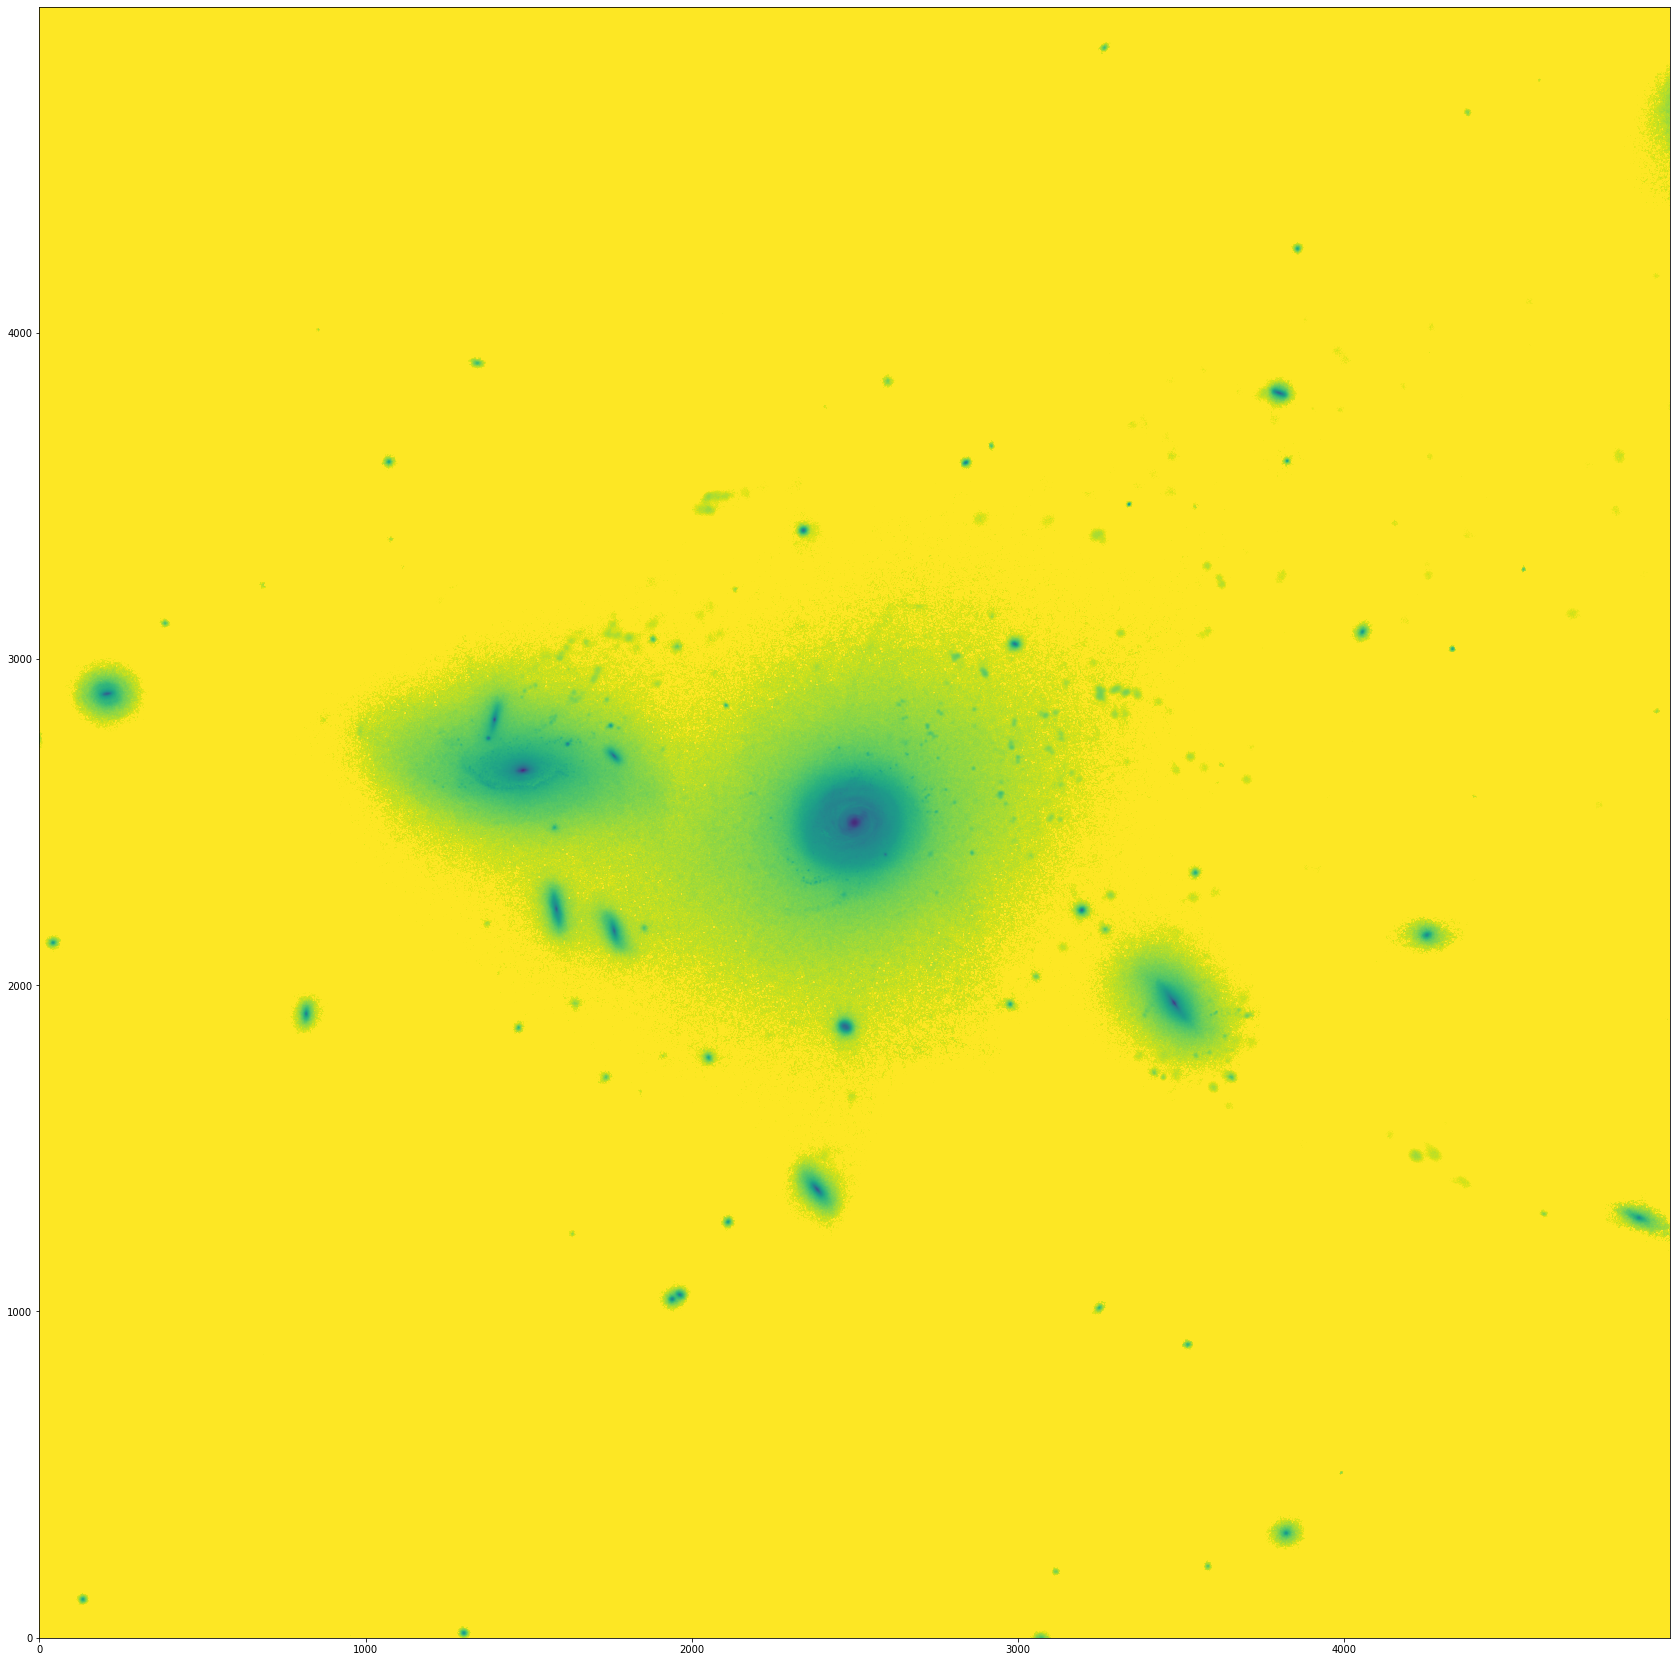

In [29]:
import matplotlib.pyplot as plt

sim_tag = 'TNG50-1'
snap = 91
sub = 70250
cam = 'v0'

name = f'/lustre/work/connor.bottrell/Simulations/IllustrisTNG/TNG50-1/postprocessing/SKIRT9/Photometry/{snap:03}/shalo_{snap:03}-{sub}_{cam}_photo.fits'

data = fits.getdata(name,'SUBARU_HSC.I')
hdr = fits.getheader(name,'SUBARU_HSC.I')
print(hdr.keys)

fig,ax = plt.subplots(figsize=(30,30))

ax.imshow(data,origin='lower',vmin=14,vmax=26)


In [32]:
import pandas as pd

df = pd.read_csv('Catalogues/HSC-dr3-s20a_wide-photoz_mizuki-CLEAN.csv',comment='#')

df = df.sample(1000000,random_state=np.random.RandomState())

df.to_csv('Catalogues/HSC-dr3-s20a_wide-photoz_mizuki-CLEAN_TESTING.csv',index=False)

Filename: Cutouts/4-cutout-HSC-I-9599-s21a_wide.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      30   ()      
  1                1 ImageHDU        31   (3929, 3930)   float32   
  2                1 ImageHDU        48   (3929, 3930)   int32   
  3                1 ImageHDU        31   (3929, 3930)   float32   


<ipython-input-32-24ecc189f62b>:60: RuntimeWarning: invalid value encountered in log10
  axarr[0].imshow((-2.5*np.log10(img/0.168**2)+27),vmin=16,vmax=24,origin='lower',aspect='auto')


1.5803129e-06
1.059187701501054e-06


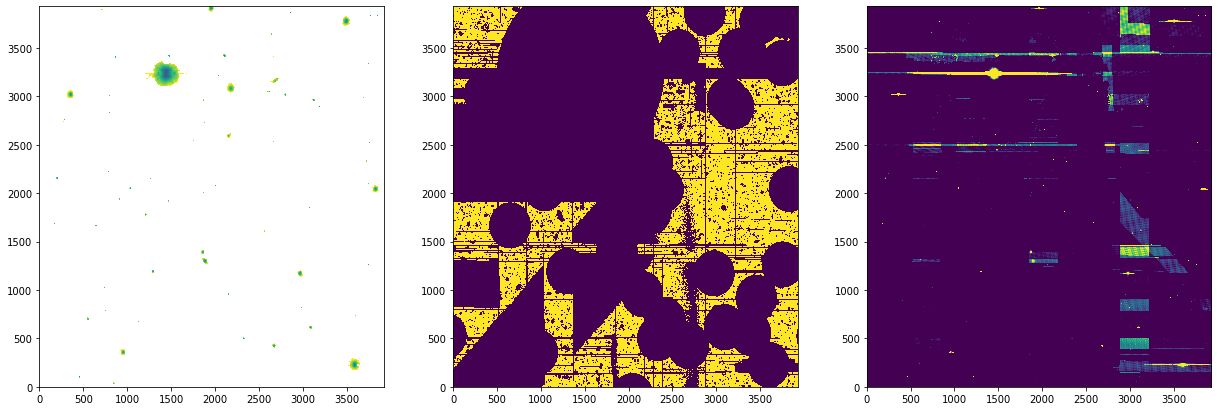

In [32]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.wcs import WCS

def coord_mask(filename,keys=['MP_BAD', 'MP_BRIGHT_OBJECT', 'MP_CLIPPED', 
                              'MP_CR', 'MP_CROSSTALK','MP_DETECTED',
                              'MP_DETECTED_NEGATIVE','MP_EDGE', 
                              'MP_INEXACT_PSF', 'MP_INTRP', 
                              'MP_NOT_DEBLENDED', 'MP_NO_DATA', 'MP_REJECTED',
                              'MP_SAT', 'MP_SENSOR_EDGE', 'MP_SUSPECT', 
                              'MP_UNMASKEDNAN']):
    '''
    Coordinate mask for insertions. Assumes that the mask is the 2nd hdu object. Use all flags by default (i.e. only pixels with no flags are used for insertions).
    '''
    mask_hdr = fits.getheader(filename,2)
    mask_dat = fits.getdata(filename,2).astype(np.uint32)
    mask_out = np.ones_like(mask_dat)
    
    for key in keys:
        mask_out[(mask_dat & 2**mask_hdr[key]).astype(bool)]=0
    return mask_out.astype(np.int8)
    
filename = 'Cutouts/4-cutout-HSC-I-9599-s21a_wide.fits'

hdu = fits.open(filename)
img = hdu[1].data

mask_keys=['MP_BAD', 'MP_BRIGHT_OBJECT', 'MP_CLIPPED', 'MP_CR', 
           'MP_CROSSTALK', 'MP_DETECTED', 'MP_DETECTED_NEGATIVE', 'MP_EDGE', 
           'MP_INEXACT_PSF', 'MP_INTRP', 'MP_NOT_DEBLENDED', 'MP_NO_DATA',
           'MP_REJECTED', 'MP_SAT', 'MP_SENSOR_EDGE', 'MP_SUSPECT', 
           'MP_UNMASKEDNAN']
            
mask = coord_mask(filename,keys=mask_keys)

npixels_hsc = 2048

nrows,ncols = mask.shape
hw = int(np.ceil(npixels_hsc/2))
# pixels within 10% of image size from either side
border_mask = np.zeros(mask.shape,dtype=np.int8)
row_min,row_max = max(hw,int(0.1*nrows)),min(nrows-hw,int(0.9*nrows))
col_min,col_max = max(hw,int(0.1*ncols)),min(ncols-hw,int(0.9*ncols))
border_mask[row_min:row_max,col_min:col_max]=1
# map of possible injection sites
# mask *= border_mask
# index of injection site for map
index = np.random.choice(int(np.sum(mask)))
# coordinates of injection site 
coords = np.argwhere(mask)[index]

row,col = coords

w = WCS(hdu[3].header)

    


fig,axarr = plt.subplots(1,3,figsize=(21,7))


axarr[0].imshow((-2.5*np.log10(img/0.168**2)+27),vmin=16,vmax=24,origin='lower',aspect='auto')
axarr[1].imshow(mask,vmin=0,vmax=1,origin='lower',interpolation='None',aspect='auto')

# axarr[1].scatter(col,row,s=100)

ra,dec = w.all_pix2world(col,row,1,ra_dec_order=True)

col,row = w.all_world2pix(ra,dec,1,ra_dec_order=True)

# axarr[1].scatter(col,row,s=50,c='red')


hdulist = fits.open(filename)
hdulist.info()
f0 = hdulist[0].header['FLUXMAG0']
img = img/f0*1e9
var = np.var(img[mask==1])
print(var)

variance = fits.getdata(filename,3)

print(np.median(variance[mask==1])*(1e9/f0)**2)
axarr[2].imshow(variance,vmin=0.0063,vmax=0.01,origin='lower',interpolation='None',aspect='auto')



In [50]:
print(i)
print(value)

354
354


In [30]:
filters = 'grizy'
len(filters)

5

Filename: /lustre/work/connor.bottrell/Simulations/IllustrisTNG/TNG50-1/postprocessing/HSC_SSP/059/shalo_059-95226_v0_HSC_GRIZY.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SUBARU_HSC.G    1 PrimaryHDU      35   (192, 192)   float64   
  1  SUBARU_HSC.G MASK    1 ImageHDU         8   (192, 192)   int32   
  2  SUBARU_HSC.G VARIANCE    1 ImageHDU         8   (192, 192)   float32   
  3  SUBARU_HSC.R    1 ImageHDU        36   (192, 192)   float64   
  4  SUBARU_HSC.R MASK    1 ImageHDU         8   (192, 192)   int32   
  5  SUBARU_HSC.R VARIANCE    1 ImageHDU         8   (192, 192)   float32   
  6  SUBARU_HSC.I    1 ImageHDU        36   (192, 192)   float64   
  7  SUBARU_HSC.I MASK    1 ImageHDU         8   (192, 192)   int32   
  8  SUBARU_HSC.I VARIANCE    1 ImageHDU         8   (192, 192)   float32   
  9  SUBARU_HSC.Z    1 ImageHDU        36   (192, 192)   float64   
 10  SUBARU_HSC.Z MASK    1 ImageHDU         8   (192, 192)   int32   
 11  SUBARU_HSC.Z 

<ipython-input-113-5072526bae8c>:34: RuntimeWarning: invalid value encountered in log10
  data_b = -2.5*np.log10(fits.getdata(filename,'SUBARU_HSC.I')/0.168**2)+22.5
<ipython-input-113-5072526bae8c>:36: RuntimeWarning: invalid value encountered in log10
  data_g = -2.5*np.log10(fits.getdata(filename,'SUBARU_HSC.Z')/0.168**2)+22.5
<ipython-input-113-5072526bae8c>:38: RuntimeWarning: invalid value encountered in log10
  data_r = -2.5*np.log10(fits.getdata(filename,'SUBARU_HSC.Y')/0.168**2)+22.5


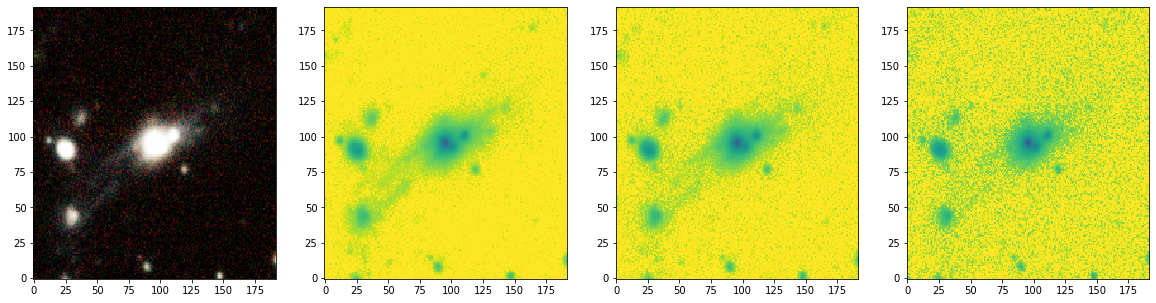

In [113]:
def make_bottrell_rgb(rgb,stretch=99,q=5,scale_r=1.,scale_g=1.,scale_b=1.):
    '''Convert images in rgb format (x,y,images).'''
    # assume images are in mag/arcsec2
    rgb = 10**(0.4*(22.5-rgb))
    rgb_scaled = np.tanh(rgb/np.percentile(rgb,stretch)*q)
    rgb_scaled[...,0]*=scale_r
    rgb_scaled[...,1]*=scale_g
    rgb_scaled[...,2]*=scale_b
    return rgb_scaled


def rgb_plot(ax,out_dir,out_prefix,bands=['g','r','i'],scale_r=1.,scale_g=1.,scale_b=1.2,q=1.):
    '''Plot rgb colour image on ax from 3 bands ordered blue/green/red.'''
    data_b = hsc_calibrate_msb(f'{out_dir}/{out_prefix}_{bands[0]}.fits')
    data_g = hsc_calibrate_msb(f'{out_dir}/{out_prefix}_{bands[1]}.fits')
    data_r = hsc_calibrate_msb(f'{out_dir}/{out_prefix}_{bands[2]}.fits')
    rgb = np.stack([data_r,data_g,data_b])
    rgb = rgb.transpose((1,2,0))
    rgb_scaled = make_bottrell_rgb(rgb,scale_r=scale_r,scale_g=scale_g,scale_b=scale_b,q=q)
    ax.imshow(rgb_scaled, origin='lower', interpolation='None',aspect='auto')
    return


filename = '/lustre/work/connor.bottrell/Simulations/IllustrisTNG/TNG50-1/postprocessing/HSC_SSP/059/shalo_059-95226_v0_HSC_GRIZY.fits'

hdu_list = fits.open(filename)
hdu_list.info()

scale_r=1.
scale_g=1.
scale_b=1.
q=2

data_b = -2.5*np.log10(fits.getdata(filename,'SUBARU_HSC.I')/0.168**2)+22.5
data_b[np.isnan(data_b)]=99
data_g = -2.5*np.log10(fits.getdata(filename,'SUBARU_HSC.Z')/0.168**2)+22.5
data_g[np.isnan(data_g)]=99
data_r = -2.5*np.log10(fits.getdata(filename,'SUBARU_HSC.Y')/0.168**2)+22.5
data_r[np.isnan(data_r)]=99

rgb = np.stack([data_r,data_g,data_b])
rgb = rgb.transpose((1,2,0))
rgb_scaled = make_bottrell_rgb(rgb,scale_r=scale_r,scale_g=scale_g,scale_b=scale_b,q=q)
fig,axarr = plt.subplots(1,4,figsize=(20,5))

ax = axarr[0]
ax.imshow(rgb_scaled, origin='lower', interpolation='None',aspect='auto')
ax = axarr[1]
ax.imshow(data_b, vmin=14,vmax=26,origin='lower', interpolation='None',aspect='auto')
ax = axarr[2]
ax.imshow(data_g, vmin=14,vmax=26,origin='lower', interpolation='None',aspect='auto')
ax = axarr[3]
ax.imshow(data_r, vmin=14,vmax=26,origin='lower', interpolation='None',aspect='auto')


In [5]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.wcs import WCS

def coord_mask(filename,keys=['MP_BAD', 'MP_BRIGHT_OBJECT', 'MP_CLIPPED', 
                              'MP_CR', 'MP_CROSSTALK','MP_DETECTED',
                              'MP_DETECTED_NEGATIVE','MP_EDGE', 
                              'MP_INEXACT_PSF', 'MP_INTRP', 
                              'MP_NOT_DEBLENDED', 'MP_NO_DATA', 'MP_REJECTED',
                              'MP_SAT', 'MP_SENSOR_EDGE', 'MP_SUSPECT', 
                              'MP_UNMASKEDNAN']):
    '''
    Coordinate mask for insertions. Assumes that the mask is the 2nd hdu object. Use all flags by default (i.e. only pixels with no flags are used for insertions).
    '''
    mask_hdr = fits.getheader(filename,2)
    mask_dat = fits.getdata(filename,2).astype(np.uint32)
    mask_out = np.ones_like(mask_dat)
    
    for key in keys:
        mask_out[(mask_dat & 2**mask_hdr[key]).astype(bool)]=0
    return mask_out.astype(np.int8)
    
filename = 'Cutouts/4-cutout-HSC-I-9599-s21a_wide.fits'

hdu = fits.open(filename)
img = hdu[1].data

mask_keys=['MP_BAD', 'MP_BRIGHT_OBJECT', 'MP_CLIPPED', 'MP_CR', 
           'MP_CROSSTALK', 'MP_DETECTED', 'MP_DETECTED_NEGATIVE', 'MP_EDGE', 
           'MP_INEXACT_PSF', 'MP_INTRP', 'MP_NOT_DEBLENDED', 'MP_NO_DATA',
           'MP_REJECTED', 'MP_SAT', 'MP_SENSOR_EDGE', 'MP_SUSPECT', 
           'MP_UNMASKEDNAN']
            
mask = coord_mask(filename,keys=mask_keys)

npixels_hsc = 2048

nrows,ncols = mask.shape
hw = int(np.ceil(npixels_hsc/2))
# pixels within 10% of image size from either side
border_mask = np.zeros(mask.shape,dtype=np.int8)
row_min,row_max = max(hw,int(0.1*nrows)),min(nrows-hw,int(0.9*nrows))
col_min,col_max = max(hw,int(0.1*ncols)),min(ncols-hw,int(0.9*ncols))
border_mask[row_min:row_max,col_min:col_max]=1
# map of possible injection sites
# mask *= border_mask
# index of injection site for map
index = np.random.choice(int(np.sum(mask)))
# coordinates of injection site 
coords = np.argwhere(mask)[index]

row,col = coords

w = WCS(hdu[3].header)

    


fig,axarr = plt.subplots(1,3,figsize=(21,7))


axarr[0].imshow((-2.5*np.log10(img/0.168**2)+27),vmin=16,vmax=24,origin='lower',aspect='auto')
axarr[1].imshow(mask,vmin=0,vmax=1,origin='lower',interpolation='None',aspect='auto')

# axarr[1].scatter(col,row,s=100)

ra,dec = w.all_pix2world(col,row,1,ra_dec_order=True)

col,row = w.all_world2pix(ra,dec,1,ra_dec_order=True)

# axarr[1].scatter(col,row,s=50,c='red')


hdulist = fits.open(filename)
hdulist.info()
f0 = hdulist[0].header['FLUXMAG0']
img = img/f0*1e9
var = np.var(img[mask==1])
print(var)

variance = fits.getdata(filename,3)

print(np.median(variance[mask==1])*(1e9/f0)**2)
axarr[2].imshow(variance,vmin=0.0063,vmax=0.01,origin='lower',interpolation='None',aspect='auto')


[1]

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1571                                                  NAXIS2  =                 1571                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               EXTNAME = 'SUBARU_HSC.I'       / extension name                                 ORIGIN  = 'SKIRT 9 Simulation' / Image origin                                   SIMTAG  = 'TNG50-1 '           / Simulation name                                SNAPNUM =                   91 / Simulation snapshot                            SUBHALO =                70250 / Subhalo ID                                     CAMERA  = 'v0      '           / Camera 

<ipython-input-25-be7dfaf4a761>:19: RuntimeWarning: invalid value encountered in log10
  return -2.5*np.log10(x/0.168)+22.5


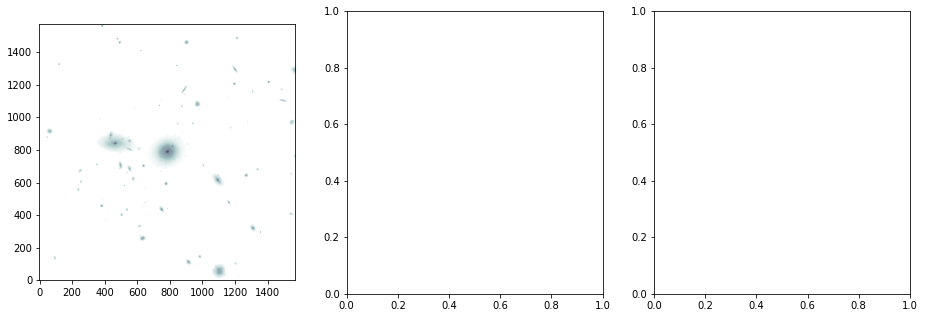

In [25]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

filename = '/lustre/work/connor.bottrell/Simulations/IllustrisTNG/TNG50-1/postprocessing/SKIRT9/HSC_SSP/091/shalo_091-70250_v0_HSC_GRIZY.fits'

hdu_list = fits.open(filename)
#hdu_list.info()

header = hdu_list['SUBARU_HSC.I'].header

print(header)

fig,axarr = plt.subplots(1,3,figsize=(15.6,5.2))

ax = axarr[0]

def mag_scale(x,pixscale=0.168):
    return -2.5*np.log10(x/0.168)+22.5

ax.imshow(mag_scale(hdu_list['SUBARU_HSC.I'].data),
          vmin=14,vmax=26,origin='lower',cmap='bone')

In [26]:
-5*np.log10(0.168)

3.873453591370686

In [ ]:
from hsc_utils import hsc_sql
import pandas as pd

def main():

    dr='dr3'
    rerun = 's20a_wide'
    csv_name = f'Catalogues/HSC-{dr}-{rerun}-photoz_mizuki.csv'
    clean = True
    
    sql_cmd = [
        f'SELECT f.object_id, f.ra, f.dec, ,
        f'z.prob_gal, z.prob_star, z.prob_qso',
        f'FROM {rerun}.forced as f',
        f'LEFT JOIN {rerun}.photoz_mizuki as z',
        f'ON f.object_id = z.object_id',
        f'WHERE z.photoz_median>0.01 and z.photoz_median<2',
              ]
    sql_cmd = ' '.join(sql_cmd)
    if clean:
        sql_cmd += ' '+' '.join([f'AND {cnd}' for cnd in hsc_sql.hsc_coadd_cnds(rerun)])
    sql_cmd += f' ORDER BY f.object_id;'
    
    df = hsc_sql.load_sql_df(csv_name,dr=dr,sql_cmd=sql_cmd)
    
    df = df.loc[(df.photoz_risk_best<0.25) & (df.reduced_chisq<5)]
    
    import matplotlib.pyplot as plt
    import numpy as np
    xmin,xmax=0.,3.
    fig,ax = plt.subplots(figsize=(7.5,5))
    xedges = np.linspace(xmin,xmax,300)
    xwidths = xedges[1:]-xedges[:-1]
    H,xedges = np.histogram(df['photoz_best'],bins=xedges,density=False)
    ax.bar(xedges[:-1],H,width=xwidths,align='edge')
    
    # clean photoz catalogue
    df.to_csv(f'Catalogues/HSC-{dr}-{rerun}-photoz_mizuki-CLEAN.csv',columns=['object_id','ra','dec','photoz_best'],index=False)
    
if __name__=='__main__':
    main()

In [4]:
import pandas as pd
from hsc_utils import hsc_sql

dr = 'pdr3'
rerun = 's20'
filename = 'Catalogues/HSC-dr3-s20a_wide-photoz_mizuki.csv'

df = hsc_sql.load_sql_df(filename)

In [5]:
df

,object_id,ra,dec,tract,patch,photoz_best,photoz_risk_best,reduced_chisq,prob_gal,prob_star,prob_qso
0,36411448540270969,30.611445,-6.475494,8279,5,0.93,0.139571,0.3525,1.0,0.0,0.0
1,36411448540271000,30.594238,-6.474626,8279,5,0.85,0.145288,0.0550,1.0,0.0,0.0
2,36411448540271197,30.592653,-6.469386,8279,5,0.70,0.626696,0.7825,1.0,0.0,0.0
3,36411448540271205,30.617303,-6.469029,8279,5,0.17,0.489337,1.9275,1.0,0.0,0.0
4,36411448540271228,30.594655,-6.468498,8279,5,0.58,0.413179,0.1025,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
62702566,74649168714423215,213.913158,53.186546,16973,806,0.19,0.561476,0.1550,1.0,0.0,0.0
62702567,74649168714423242,213.938407,53.188108,16973,806,0.96,0.309734,0.3575,1.0,0.0,0.0
62702568,74649168714423253,213.936381,53.188238,16973,806,1.31,0.099438,0.1975,1.0,0.0,0.0
62702569,74649168714423325,213.917004,53.189580,16973,806,0.56,0.311137,0.0425,1.0,0.0,0.0


<ipython-input-247-9e868b536896>:17: RuntimeWarning: invalid value encountered in log10
  ax.imshow(22.5-2.5*np.log10(data/0.168**2),vmin=18,vmax=28,cmap='bone_r',


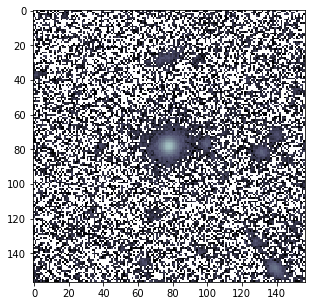

In [247]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np

snap = 91
sub =  838925
axis = 'v3'

img_name = f'/lustre/work/connor.bottrell/Simulations/IllustrisTNG/TNG50-1/postprocessing/SKIRT9/HSC_SSP/{snap:03}/shalo_{snap:03}-{sub}_{axis}_HSC_GRIZY.fits'

fig,ax = plt.subplots(figsize=(5,5))
with fits.open(img_name,mode='readonly') as hdul:
    data = hdul['Subaru_HSC.I'].data
    mdpt = int(data.shape[0]/2)
    hw = 200
    #data = data[mdpt-hw:mdpt+hw,mdpt-hw:mdpt+hw]
ax.imshow(22.5-2.5*np.log10(data/0.168**2),vmin=18,vmax=28,cmap='bone_r',
          interpolation='None')